In [21]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [17]:
synthetic_df = pd.read_csv('./Output_2018_2021_Braidwood_periodic/synthetic.csv')
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df.tail()

,Year,hour,price
35035,2021,8756,35.809725
35036,2021,8757,34.840783
35037,2021,8758,27.441728
35038,2021,8759,27.594318
35039,2021,8760,30.345412


In [15]:
# Read and concatenate historical data
files = ['2018_Braidwood.csv', '2019_Braidwood.csv', '2020_Braidwood.csv', '2021_Braidwood.csv']
li = []
for f in files: 
  df = pd.read_csv(f, index_col=None, header=0)
  li.append(df)
historic_df = pd.concat(li, axis=0, ignore_index=True)
historic_df.drop(columns=['hour'], inplace=True)
# Add time info to historic prices
time_df = synthetic_df.drop(columns=['price'])
historic_df = pd.concat([historic_df, time_df], axis=1)
historic_df.tail()

,price,Year,hour
35035,23.41,2021,8756
35036,22.45,2021,8757
35037,22.07,2021,8758
35038,21.04,2021,8759
35039,20.37,2021,8760


In [19]:
# Concatenate historic and synthetic prices with a tag
pieces = {'historical': historic_df, 'synthetic':synthetic_df}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,type,price,Year,hour
0,historical,259.890000,2018,1
1,historical,112.930000,2018,2
2,historical,192.669999,2018,3
3,historical,103.430001,2018,4
4,historical,214.030000,2018,5
...,...,...,...,...
35035,synthetic,35.809725,2021,8756
35036,synthetic,34.840783,2021,8757
35037,synthetic,27.441728,2021,8758
35038,synthetic,27.594318,2021,8759


Text(0.5, 0, '')

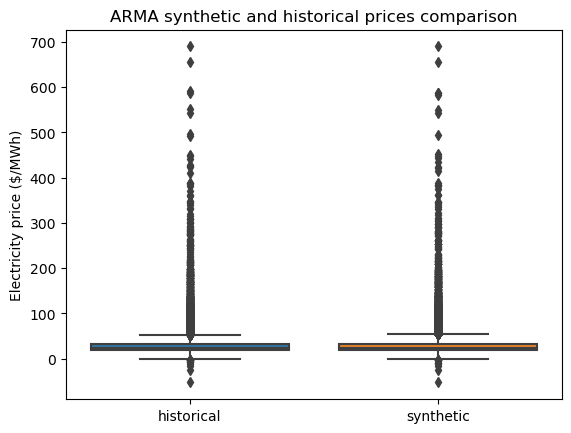

In [24]:
# Plot and save histograms and boxplots
sns.boxplot(data=prices_df, x='type', y='price')
plt.title('ARMA synthetic and historical prices comparison')
plt.ylabel('Electricity price ($/MWh)')
plt.xlabel('')


Text(0.5, 0, 'Electricity price ($/MWh)')

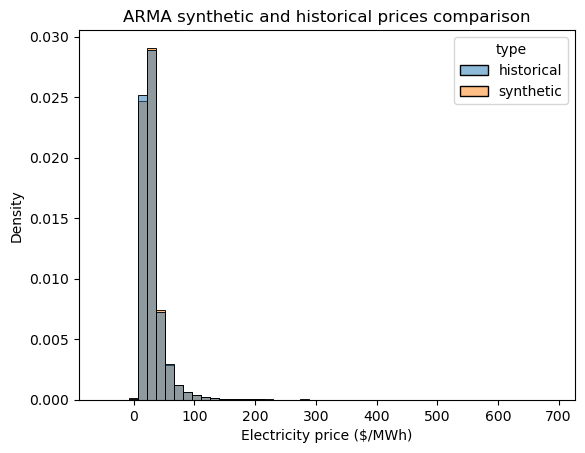

In [26]:
sns.histplot(data=prices_df, x='price', hue='type', bins=50, stat='density', common_norm=False)
plt.title('ARMA synthetic and historical prices comparison')
plt.xlabel('Electricity price ($/MWh)')

(-50.0, 200.0)

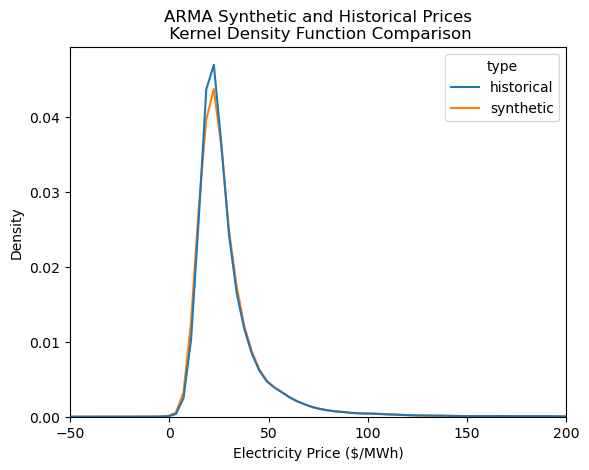

In [28]:
sns.kdeplot(x='price', data=prices_df, hue='type',common_norm=False)
plt.title('ARMA Synthetic and Historical Prices\n Kernel Density Function Comparison')
plt.xlabel('Electricity Price ($/MWh)')
plt.xlim(-50,200)

(0.0, 25.0)

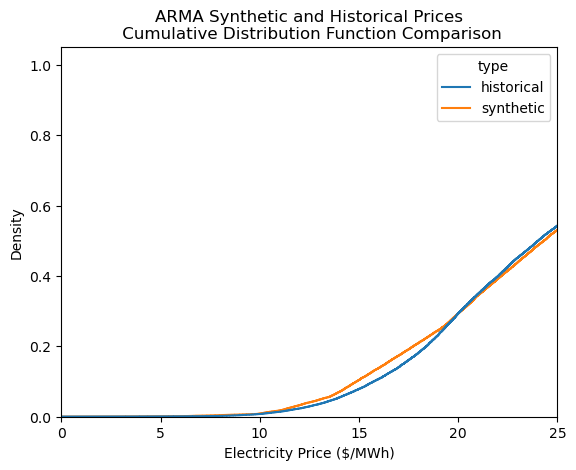

In [32]:
sns.histplot(data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=False,cumulative=True, common_norm=False)
plt.title('ARMA Synthetic and Historical Prices\n Cumulative Distribution Function Comparison')
plt.xlabel('Electricity Price ($/MWh)')
plt.xlim(0,25)

In [34]:
# T-Test to compare means, not very useful?
from scipy.stats import ttest_ind
hist_prices = prices_df.loc[prices_df.type=='historical','price'].values
synth_prices = prices_df.loc[prices_df.type=='synthetic','price'].values
stat, p_value = ttest_ind(hist_prices, synth_prices)
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-test: statistic=0.0609, p-value=0.9515


In [35]:
# Mann Whitney U Test: null hypothesis 2 groups have the same distribution
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(hist_prices, synth_prices)
print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=615061487.0000, p-value=0.6647


In [36]:
# Chi Squared Test: Test similarity between distributions
# Init dataframe
df_bins = pd.DataFrame()

# Generate bins from control group
_, bins = pd.qcut(hist_prices, q=10, retbins=True)
df_bins['bin'] = pd.cut(hist_prices, bins=bins).value_counts().index

# Apply bins to both groups
df_bins['hist_prices_observed'] = pd.cut(hist_prices, bins=bins).value_counts().values
df_bins['synth_prices_observed'] = pd.cut(synth_prices, bins=bins).value_counts().values

# Compute expected frequency in the treatment group
df_bins['synth_prices_expected'] = df_bins['hist_prices_observed'] / np.sum(df_bins['hist_prices_observed']) * np.sum(df_bins['synth_prices_observed'])

df_bins

,bin,hist_prices_observed,synth_prices_observed,synth_prices_expected
0,"(-52.77, 15.74]",3509,4567,3509.0
1,"(15.74, 18.4]",3502,3280,3502.0
2,"(18.4, 20.12]",3501,2622,3501.0
3,"(20.12, 22.02]",3513,3280,3513.0
4,"(22.02, 24.03]",3499,3323,3499.0
5,"(24.03, 26.52]",3499,3650,3499.0
6,"(26.52, 30.18]",3506,3396,3506.0
7,"(30.18, 36.04]",3505,3799,3505.0
8,"(36.04, 48.56]",3501,3584,3501.0
9,"(48.56, 690.03]",3504,3538,3504.0


In [ ]:
from scipy.stats import chisquare

stat, p_value = chisquare(df_bins['synth_prices_observed'], df_bins['synth_prices_expected'])
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")